# Homework 3
http://wiki.quantsoftware.org/index.php?title=CompInvesti_Homework_3

In [1]:
from lib import DataAccess as da
from lib import qsdateutil as du
from lib import EventProfiler as ep
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Market Simulation Tool

In [2]:
def marketsim(cash,orders,values=None):
    df_od = pd.read_csv('data/orders/'+orders+'.csv')
    
    #==================
    # => Organize Dates
    # new column date
    dates = list()
    for y,m,d in zip(df_od['year'],df_od['month'],df_od['day']):
        dates.append(dt.datetime(y, m, d,16))
    df_od['date'] = dates
    # date range
    start_date = min(df_od['date'])
    end_date = max(df_od['date'])
    dt_timeofday = dt.timedelta(hours=16)
    time_stamps = du.getNYSEdays(start_date, end_date,dt_timeofday)
    
    #====================
    # => Get Trading Data
    dataobj = da.DataAccess('Yahoo')
    symbols = set(df_od['symbol'])
    keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
    ldf_data = dataobj.get_data(time_stamps, symbols, keys)
    data = dict(zip(keys, ldf_data))['close']
    
    #====================
    # => Out Data
    df_out = pd.DataFrame()
    df_out['year'] = [d.year for d in data.index]
    df_out['month'] = [d.month for d in data.index]
    df_out['day'] = [d.day for d in data.index]
    df_out['date'] = data.index
    for s in symbols:
        df_out[s] = 0
    df_out['stop_cash'] = cash
    df_out['work_cash'] = 0
    
    #====================
    # => Orders Update
    for index, row in df_od.iterrows():
        # Data
        date = row['date']
        y,m,d = row['year'],row['month'],row['day']
        close_price = data.loc[date][row['symbol']]
        symbol = row['symbol']
        op = row['op']
        shares = row['n_shares']
        
        # Operation
        update_col = np.array(df_out['date']>=date)
        if op == 'Buy':
            df_out['stop_cash'] -= update_col*close_price*shares
            df_out[symbol]+=update_col*shares
        elif op == 'Sell':
            df_out['stop_cash'] += update_col*close_price*shares
            df_out[symbol] -= update_col*shares
        else:
            print('Error:',op, 'is not a operation.')
    # Work Cash
    for s in symbols:
        df_out['work_cash'] += df_out[s].values*data[s].values

    #====================
    # => Clear Out Data
    df_out['cash'] = df_out['stop_cash']+df_out['work_cash']
    for s in symbols:
        del df_out[s]
    del df_out['date']
    #outputs
    if values is not None:
        df_out.to_csv('data/values/'+values+'.csv',index = False)
    return df_out

In [3]:
data = marketsim(1000000,'orders-short','values-short')
data.head()

,year,month,day,stop_cash,work_cash,cash
0,2011,1,5,501145.0,498855.0,1000000.0
1,2011,1,6,501145.0,498450.0,999595.0
2,2011,1,7,501145.0,502020.0,1003165.0
3,2011,1,10,501145.0,511485.0,1012630.0
4,2011,1,11,501145.0,510270.0,1011415.0


### Portfolio Analysis Tool

In [4]:
def analyze(values,comparisons = None):
    # Data Portfolio
    df = pd.read_csv('data/values/'+values+'.csv')
    cash = df['cash'].values
    dates = list()
    for y,m,d in zip(df['year'],df['month'],df['day']):
        dates.append(dt.datetime(y, m, d,16))
    
    out = list()
    # Data Comparison
    if comparisons is not None:
        if type(comparisons) is not list:
            comparisons = [comparisons]
        #date
        start_date = min(dates)
        end_date = max(dates)
        dt_timeofday = dt.timedelta(hours=16)
        time_stamps = du.getNYSEdays(start_date, end_date,dt_timeofday)
        #get data
        dataobj = da.DataAccess('Yahoo')
        keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
        ldf_data = dataobj.get_data(time_stamps, comparisons, keys)
        data = dict(zip(keys, ldf_data))['close']
        #analyses
        for c in comparisons:
            daily_ret = [0.0]+[data[c][i+1]/data[c][i]-1 for i in range(len(data)-1)]
            daily_ret_avg = np.average(daily_ret)
            std = np.std(daily_ret)
            sharpe = np.sqrt(252)*daily_ret_avg/std
            cum_ret = data[c][-1]/data[c][0]
            out.append([c,daily_ret_avg,std,sharpe,cum_ret])
            #plots
            ret = cash[0]*data[c]/data[c][0]
            plt.plot(dates,ret)

    # Analyse
    daily_ret = [0.0]+[cash[i+1]/cash[i]-1 for i in range(len(cash)-1)]
    daily_ret_avg = np.average(daily_ret)
    std = np.std(daily_ret)
    sharpe = np.sqrt(252)*daily_ret_avg/std
    cum_ret = cash[-1]/cash[0]
    out.append([values,daily_ret_avg,std,sharpe,cum_ret])
    
    # To Dataframe
    col = ['symbol','daily_ret_avg','daily_ret_std','sharpe','cum_ret']
    df_out = pd.DataFrame(out,columns=col)
    # Plot
    plt.plot(dates,cash)
    plt.legend(df_out['symbol'])
    plt.ylabel('Return')
    plt.xlabel('Date')
    plt.show()
    
    out_dict = {"daily_ret_avg":daily_ret_avg,
                "daily_ret_std":std,
                "sharpe":sharpe,
                "cum_ret":cum_ret}
    return df_out

#### Examples

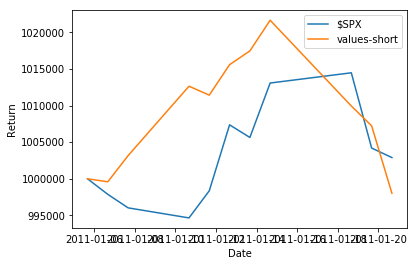

,symbol,daily_ret_avg,daily_ret_std,sharpe,cum_ret
0,$SPX,0.000275,0.004930,0.886475,1.002898
1,values-short,-0.000162,0.005736,-0.449182,0.998035


In [5]:
marketsim(1000000,'orders-short','values-short')
analyze("values-short","$SPX")

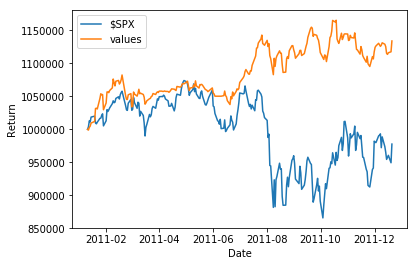

,symbol,daily_ret_avg,daily_ret_std,sharpe,cum_ret
0,$SPX,0.000017,0.014909,0.018339,0.977594
1,values,0.000549,0.007175,1.215405,1.133860


In [6]:
marketsim(1000000,'orders','values')
analyze("values","$SPX")

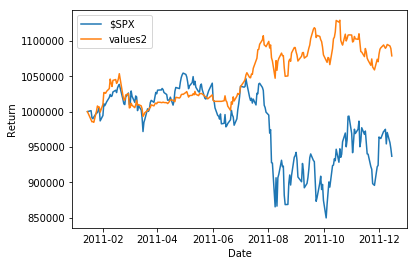

,symbol,daily_ret_avg,daily_ret_std,sharpe,cum_ret
0,$SPX,-0.000167,0.014991,-0.177205,0.937042
1,values2,0.000352,0.007080,0.788985,1.078753


In [7]:
marketsim(1000000,'orders2','values2')
analyze("values2","$SPX")